<a href="https://colab.research.google.com/github/JavierDoom/Programa-de-Fidelizaci-n-de-Clientes./blob/main/mejor_tarifa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [ ]:


# Cargar todas las librerías
import pandas as pd
import math as mt
from math import factorial
import numpy as np
from scipy import stats as st
import seaborn as sns



## Cargar datos

In [ ]:
# Carga los archivos de datos en diferentes DataFrames
#df_ordenes= pd.read_csv('/datasets/instacart_orders.csv')
df_calls = pd.read_csv("/datasets/megaline_calls.csv")
df_internet = pd.read_csv ("/datasets/megaline_internet.csv")
df_messages = pd.read_csv ("/datasets/megaline_messages.csv")
df_plans = pd.read_csv ("/datasets/megaline_plans.csv")
df_users = pd.read_csv ("/datasets/megaline_users.csv")

## Preparar los datos

[Los datos para este proyecto se dividen en varias tablas. Explora cada una para tener una comprensión inicial de los datos. Si es necesario, haz las correcciones requeridas en cada tabla.]

## Tarifas

In [ ]:

# Imprime la información general/resumida sobre el DataFrame de las tarifas

df_plans.info()
df_plans.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,45.000000,8.50000,0.020000,0.020000
std,671.751442,10861.160159,1767.766953,35.355339,2.12132,0.014142,0.014142
min,50.000000,15360.000000,500.000000,20.000000,7.00000,0.010000,0.010000
25%,287.500000,19200.000000,1125.000000,32.500000,7.75000,0.015000,0.015000
50%,525.000000,23040.000000,1750.000000,45.000000,8.50000,0.020000,0.020000
75%,762.500000,26880.000000,2375.000000,57.500000,9.25000,0.025000,0.025000
max,1000.000000,30720.000000,3000.000000,70.000000,10.00000,0.030000,0.030000


In [ ]:

# Imprime una muestra de los datos para las tarifas
df_plans.sample()



,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf


In [ ]:
# === Tabla de distribuciones preliminares de variables numéricas ===

# Seleccionamos columnas numéricas
numeric_cols = df_plans.select_dtypes(include=['int64', 'float64']).columns

# Creamos un DataFrame con las estadísticas clave
summary_table = pd.DataFrame({
    'min': df_plans[numeric_cols].min(),
    'max': df_plans[numeric_cols].max(),
    'mean': df_plans[numeric_cols].mean(),
    'median': df_plans[numeric_cols].median(),
    'std': df_plans[numeric_cols].std(),
    'n_unique': df_plans[numeric_cols].nunique()
})

# Mostramos la tabla
print("=== Distribuciones preliminares de variables numéricas ===")
summary_table

=== Distribuciones preliminares de variables numéricas ===


,min,max,mean,median,std,n_unique
messages_included,50.00,1000.00,525.00,525.00,671.751442,2
mb_per_month_included,15360.00,30720.00,23040.00,23040.00,10861.160159,2
minutes_included,500.00,3000.00,1750.00,1750.00,1767.766953,2
usd_monthly_pay,20.00,70.00,45.00,45.00,35.355339,2
usd_per_gb,7.00,10.00,8.50,8.50,2.121320,2
usd_per_message,0.01,0.03,0.02,0.02,0.014142,2
usd_per_minute,0.01,0.03,0.02,0.02,0.014142,2


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

Si lo que logro detectar es que algunos datos siguen siendo flotantes, hay diferencia en la parte decimal de algunos otros. La unica solucion es que obviamente pasemos todos los datos a un solo tipo de dato para tener un mejor manejo de ellos.

## Corregir datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [ ]:
# === Carga del DataFrame de tarifas ===
df_plans = pd.read_csv("/datasets/megaline_plans.csv")

# === Validación inicial ===
print("Información general del DataFrame:")
df_plans.info()
print("\nResumen estadístico preliminar:")
df_plans.describe()

# === Corrección de tipos de datos ===

# Columnas de costos → float
costos_columnas = ['usd_monthly_pay', 'usd_per_gb', 'usd_per_message', 'usd_per_minute']
for col in costos_columnas:
    df_plans[col] = pd.to_numeric(df_plans[col], errors='coerce')  # convierte valores inválidos a NaN

# Columnas de cantidades → int
cantidad_columnas = ['messages_included', 'mb_per_month_included', 'minutes_included']
for col in cantidad_columnas:
    df_plans[col] = pd.to_numeric(df_plans[col], errors='coerce').astype('Int64')  # permite NaN en enteros

# === Detección de problemas de datos ===
print("\nValores nulos por columna:")
print(df_plans.isnull().sum())

# Detectar valores negativos en columnas donde no deberían existir
for col in costos_columnas + cantidad_columnas:
    if (df_plans[col] < 0).any():
        print(f"⚠ Atención: valores negativos detectados en la columna '{col}'")

# === Visualización final ===
df_plans.dtypes
df_plans.head()





Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes

Resumen estadístico preliminar:

Valores nulos por columna:
messages_included        0
mb_per_month_included    0
minutes_included         0
usd_monthly_pay          0
usd_per_gb               0
usd_per_message          0
usd_per_minute           0
plan_name                0
d

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [ ]:
# --- Enriquecimiento de datos de df_plans ---

# Crear métricas derivadas del plan
# Convertir megabytes incluidos a gigabytes
df_plans['gb_included'] = df_plans['mb_per_month_included'] / 1024

# Costo total por unidad extra (por minuto + por mensaje + por GB)
df_plans['total_cost_extra'] = df_plans['usd_per_minute'] + df_plans['usd_per_message'] + df_plans['usd_per_gb']

# Clasificar los planes según costo
def clasificar_plan(row):
    if row['usd_monthly_pay'] < 50:
        return 'bajo'
    elif row['usd_monthly_pay'] < 70:
        return 'medio'
    else:
        return 'alto'

df_plans['plan_category'] = df_plans.apply(clasificar_plan, axis=1)

# Mostrar resultado
print("DataFrame enriquecido:")
print(df_plans)



DataFrame enriquecido:
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  \
0               20          10             0.03            0.03      surf   
1               70           7             0.01            0.01  ultimate   

   gb_included  total_cost_extra plan_category  
0         15.0             10.06          bajo  
1         30.0              7.02          alto  


## Usuarios/as

In [ ]:




# Imprime la información general/resumida sobre el DataFrame de usuarios
df_users.info()
df_users.describe()






<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age
count,500.000000,500.000000
mean,1249.500000,45.486000
std,144.481833,16.972269
min,1000.000000,18.000000
25%,1124.750000,30.000000
50%,1249.500000,46.000000
75%,1374.250000,61.000000
max,1499.000000,75.000000


In [ ]:


# Imprime una muestra de datos para usuarios
df_users.sample()




,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
55,1055,Patrick,Mclean,52,"Portland-Vancouver-Hillsboro, OR-WA MSA",2018-01-13,surf,NaN


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?] En el DataFrame df_plans, los costos se convirtieron a float y las cantidades incluidas a int, lo que permite cálculos correctos. No hay valores nulos, pero conviene verificar la consistencia de unidades (MB vs GB) y normalizar los nombres de los planes para análisis comparativos.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [ ]:
import pandas as pd

# Información general del DataFrame de usuarios
df_users.info()
df_users.describe()
df_users.sample(5)  # Muestra aleatoria de 5 filas

# Convertir columnas de fecha a datetime con formato especificado
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d', errors='coerce')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d', errors='coerce')

# Revisar tipos de datos después de la conversión
df_users.dtypes

# Filas con fechas nulas
df_users[df_users['reg_date'].isna() | df_users['churn_date'].isna()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT
...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaT
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaT
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,NaT
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaT


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [ ]:
# Crear función para clasificar por edad
def clasificar_edad(edad):
    if edad <= 30:
        return 'Joven (18-30)'
    elif edad <= 50:
        return 'Adulto (31-50)'
    else:
        return 'Mayor (51+)'

# Aplicar la función al DataFrame
df_users['grupo_edad'] = df_users['age'].apply(clasificar_edad)

# Mostrar resultado
df_users[['user_id', 'age', 'grupo_edad']].sample(10)

,user_id,age,grupo_edad
154,1154,53,Mayor (51+)
31,1031,52,Mayor (51+)
302,1302,62,Mayor (51+)
90,1090,30,Joven (18-30)
33,1033,28,Joven (18-30)
84,1084,21,Joven (18-30)
138,1138,66,Mayor (51+)
36,1036,70,Mayor (51+)
480,1480,46,Adulto (31-50)
196,1196,46,Adulto (31-50)


## Llamadas

In [ ]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
df_calls.info()
df_calls.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


,user_id,duration
count,137735.000000,137735.000000
mean,1247.658046,6.745927
std,139.416268,5.839241
min,1000.000000,0.000000
25%,1128.000000,1.290000
50%,1247.000000,5.980000
75%,1365.000000,10.690000
max,1499.000000,37.600000


In [ ]:
# Imprime una muestra de datos para las llamadas
df_calls.sample()


,id,user_id,call_date,duration
114118,1400_467,1400,2018-12-27,1.61


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?] Los datos de df_calls están completos y con tipos adecuados, pero algunas llamadas tienen duración 0, lo que podría requerir filtrado. Para enriquecer los datos, se pueden crear métricas como total de minutos por usuario al mes, promedio de duración por llamada o cantidad de llamadas por mes.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [ ]:
import pandas as pd

# Convertir call_date a formato datetime con formato seguro
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d', errors='coerce')

# Crear columna 'month' a partir de call_date para análisis mensual
df_calls['month'] = df_calls['call_date'].dt.to_period('M')

# Revisar información general del DataFrame
df_calls.info()

# Mostrar una muestra de los datos
df_calls.sample(5)

# Observación: llamadas con duración 0
llamadas_0 = df_calls[df_calls['duration'] == 0]
print(f"Llamadas con duración 0: {llamadas_0.shape[0]}")
llamadas_0.sample(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
 4   month      137735 non-null  period[M]     
dtypes: datetime64[ns](1), float64(1), int64(1), object(1), period[M](1)
memory usage: 5.3+ MB
Llamadas con duración 0: 26834


,id,user_id,call_date,duration,month
73150,1259_175,1259,2018-12-02,0.0,2018-12
73163,1259_190,1259,2018-04-09,0.0,2018-04
123628,1436_356,1436,2018-10-04,0.0,2018-10
52258,1187_451,1187,2018-07-28,0.0,2018-07
25085,1097_188,1097,2018-11-12,0.0,2018-11


In [ ]:
# Análisis preliminar de llamadas con duración 0

# Número total de llamadas
total_llamadas = df_calls.shape[0]

# Número y porcentaje de llamadas con duración 0
num_0 = llamadas_0.shape[0]
porcentaje_0 = (num_0 / total_llamadas) * 100

print(f"Número de llamadas con duración 0: {num_0}")
print(f"Porcentaje de llamadas con duración 0: {porcentaje_0:.2f}%")

# Distribución por usuario de las llamadas 0
llamadas_0_por_usuario = llamadas_0.groupby('user_id').size().sort_values(ascending=False)
print("\nTop 5 usuarios con más llamadas de duración 0:")
print(llamadas_0_por_usuario.head())

# Decisión preliminar
print("\nObservación:")
print("Si el porcentaje de llamadas con duración 0 es muy bajo, pueden eliminarse para análisis de consumo real. "
      "Si hay usuarios con muchas llamadas 0, conviene investigarlos antes de decidir.")

Número de llamadas con duración 0: 26834
Porcentaje de llamadas con duración 0: 19.48%

Top 5 usuarios con más llamadas de duración 0:
user_id
1077    249
1324    236
1240    228
1334    224
1362    224
dtype: int64

Observación:
Si el porcentaje de llamadas con duración 0 es muy bajo, pueden eliminarse para análisis de consumo real. Si hay usuarios con muchas llamadas 0, conviene investigarlos antes de decidir.


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [ ]:
# Convertir 'call_date' a datetime
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')

# Ahora sí podemos crear la columna 'month'
df_calls['month'] = df_calls['call_date'].dt.to_period('M')

# Agrupar por usuario y mes
calls_per_user = df_calls.groupby(['user_id', 'month']).agg(
    total_minutes=('duration', 'sum'),
    total_calls=('id', 'count'),
    avg_duration=('duration', 'mean')
).reset_index()

calls_per_user.head()

,user_id,month,total_minutes,total_calls,avg_duration
0,1000,2018-12,116.83,16,7.301875
1,1001,2018-08,171.14,27,6.338519
2,1001,2018-09,297.69,49,6.075306
3,1001,2018-10,374.11,65,5.755538
4,1001,2018-11,404.59,64,6.321719


## Mensajes

In [ ]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
df_messages.info()
df_messages.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


,user_id
count,76051.000000
mean,1245.972768
std,139.843635
min,1000.000000
25%,1123.000000
50%,1251.000000
75%,1362.000000
max,1497.000000


In [ ]:
# Imprime una muestra de datos para los mensajes
df_messages.sample()


,id,user_id,message_date
21208,1132_456,1132,2018-05-03


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]
En df_messages, la columna message_date está como texto en lugar de datetime, lo que dificulta análisis por fecha. No hay datos faltantes. Se puede corregir convirtiendo message_date a datetime y creando una columna month para agrupar mensajes por usuario y mes.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [ ]:
# Convertir message_date a datetime
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')

# Crear columna 'month' para agrupar
df_messages['month'] = df_messages['message_date'].dt.to_period('M')

# Agrupar por usuario y mes
messages_per_user = df_messages.groupby(['user_id', 'month']).agg(
    total_messages=('id', 'count')
).reset_index()

messages_per_user.head()

,user_id,month,total_messages
0,1000,2018-12,11
1,1001,2018-08,30
2,1001,2018-09,44
3,1001,2018-10,53
4,1001,2018-11,36


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [ ]:
# Convertir message_date a datetime y extraer mes/año
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])
df_messages['month'] = df_messages['message_date'].dt.to_period('M')

# Contar mensajes por usuario
messages_per_user = df_messages.groupby('user_id').agg(total_messages=('id', 'count')).reset_index()

# Clasificación por actividad de mensajes
bins_messages = [0, 20, 50, float('inf')]
labels_messages = ['Baja', 'Media', 'Alta']
messages_per_user['message_activity_level'] = pd.cut(messages_per_user['total_messages'], bins=bins_messages, labels=labels_messages)

# Unir métricas con usuarios
df_users_enriched = df_users.merge(messages_per_user, on='user_id', how='left')

# Revisar resultado
df_users_enriched.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,grupo_edad,total_messages,message_activity_level
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,Adulto (31-50),11.0,Baja
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,Joven (18-30),207.0,Alta
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT,Adulto (31-50),88.0,Alta
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT,Mayor (51+),50.0,Media
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT,Adulto (31-50),177.0,Alta


## Internet

In [ ]:

# Imprime la información general/resumida sobre el DataFrame de internet
df_internet.info()
df_internet.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


,user_id,mb_used
count,104825.000000,104825.000000
mean,1242.496361,366.713701
std,142.053913,277.170542
min,1000.000000,0.000000
25%,1122.000000,136.080000
50%,1236.000000,343.980000
75%,1367.000000,554.610000
max,1499.000000,1693.470000


In [ ]:

# Imprime una muestra de datos para el tráfico de internet
df_internet.sample()



,id,user_id,session_date,mb_used
53987,1245_20,1245,2018-07-23,256.05


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]
En los datos de internet se observa que session_date está como tipo object en lugar de datetime, lo que dificulta manipular fechas. No hay datos faltantes, y mb_used ya es numérico, por lo que está listo para análisis. Para arreglarlo, basta con convertir session_date a formato datetime y, opcionalmente, extraer mes o año para agregaciones mensuales o por usuario. Esto permitirá calcular métricas como total de MB por usuario y clasificar usuarios según su consumo de internet.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [ ]:
# Convertir session_date a datetime
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')

# Extraer mes y año en nuevas columnas
df_internet['month'] = df_internet['session_date'].dt.month
df_internet['year'] = df_internet['session_date'].dt.year

# Clasificar usuarios según su consumo total de MB
total_mb_per_user = df_internet.groupby('user_id')['mb_used'].sum().reset_index()
total_mb_per_user['usage_category'] = pd.cut(
    total_mb_per_user['mb_used'],
    bins=[-1, 1000, 5000, 10000, float('inf')],
    labels=['Muy bajo', 'Bajo', 'Medio', 'Alto']
)

# Unir la clasificación de nuevo al DataFrame principal si se desea
df_internet = df_internet.merge(total_mb_per_user[['user_id', 'usage_category']], on='user_id', how='left')

# Mostrar las primeras filas
df_internet.head()

,id,user_id,session_date,mb_used,month,year,usage_category
0,1000_13,1000,2018-12-29,89.86,12,2018,Bajo
1,1000_204,1000,2018-12-31,0.00,12,2018,Bajo
2,1000_379,1000,2018-12-28,660.40,12,2018,Bajo
3,1000_413,1000,2018-12-26,270.99,12,2018,Bajo
4,1000_442,1000,2018-12-27,880.22,12,2018,Bajo


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

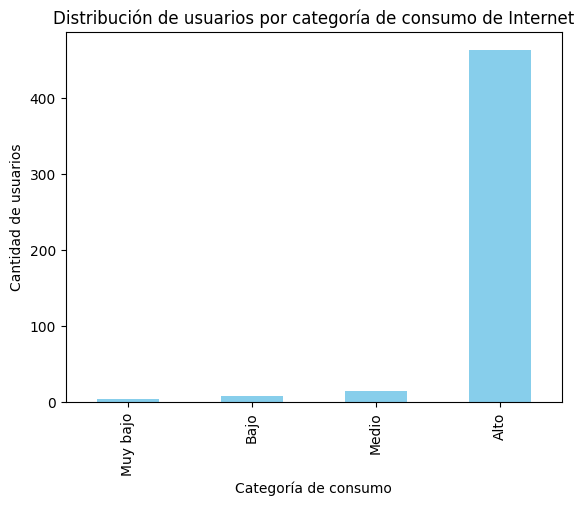

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir session_date a datetime para poder extraer mes y año
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')

# Extraer mes y año de la fecha de sesión
df_internet['month'] = df_internet['session_date'].dt.month
df_internet['year'] = df_internet['session_date'].dt.year

# Calcular consumo total de MB por usuario
user_total_mb = df_internet.groupby('user_id')['mb_used'].sum().reset_index()
user_total_mb.rename(columns={'mb_used':'total_mb'}, inplace=True)

# Clasificar usuarios según consumo total en categorías
user_total_mb['usage_category'] = pd.cut(
    user_total_mb['total_mb'],
    bins=[-1, 1000, 5000, 10000, float('inf')],
    labels=['Muy bajo', 'Bajo', 'Medio', 'Alto']
)

# Unir la categoría de consumo al DataFrame original
df_internet = df_internet.merge(user_total_mb[['user_id','usage_category']], on='user_id', how='left')

# Graficar distribución de usuarios por categoría de consumo
usage_counts = user_total_mb['usage_category'].value_counts().sort_index()
usage_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución de usuarios por categoría de consumo de Internet')
plt.xlabel('Categoría de consumo')
plt.ylabel('Cantidad de usuarios')
plt.show()


## Estudiar las condiciones de las tarifas

[Es sumamente importante entender cómo funcionan las tarifas, cómo se les cobra a los usuarios en función de su plan de suscripción. Así que te sugerimos imprimir la información de la tarifa para ver una vez más sus condiciones.]

In [ ]:
# ==============================================================
# Resumen compacto de las tarifas
# ==============================================================

# Seleccionamos solo las columnas relevantes para el análisis
columns_relevant = [
    'plan_name', 'usd_monthly_pay', 'minutes_included',
    'messages_included', 'mb_per_month_included',
    'usd_per_minute', 'usd_per_message', 'usd_per_gb'
]

df_plans_summary = df_plans[columns_relevant]

# Mostrar el resumen en formato de tabla
print("=== Resumen compacto de tarifas ===")
print(df_plans_summary.reset_index(drop=True))

=== Resumen compacto de tarifas ===
  plan_name  usd_monthly_pay  minutes_included  messages_included  \
0      surf               20               500                 50   
1  ultimate               70              3000               1000   

   mb_per_month_included  usd_per_minute  usd_per_message  usd_per_gb  
0                  15360            0.03             0.03          10  
1                  30720            0.01             0.01           7  


## Agregar datos por usuario

[Ahora que los datos están limpios, agrega los datos por usuario y por periodo para que solo haya un registro por usuario y por periodo. Esto facilitará mucho el análisis posterior.]

<div class="alert alert-block alert-warning">
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Hay pasos que repites en varias celdas. Además, nota que en este punto ya deberían estar todas las transformaciones y casteos. Hay una sección específica para eso. Luego, no es correcto que vuelvas a hacerlo aquí.

</div>

In [ ]:
# Calcula el número de llamadas hechas por cada usuario al mes

# Agrupamos y contamos llamadas
calls_per_month = (
    df_calls
    .groupby(['user_id', 'month'], as_index=False)
    .agg(calls_count=('id', 'count'))
)

# Mostramos los primeros registros
calls_per_month.head()


,user_id,month,calls_count
0,1000,2018-12,16
1,1001,2018-08,27
2,1001,2018-09,49
3,1001,2018-10,65
4,1001,2018-11,64


In [ ]:
# Calcula la cantidad de minutos usados por cada usuario al mes

# Agrupamos por usuario y mes, y sumamos la duración de las llamadas
minutes_per_month = (
    df_calls
    .groupby(['user_id', 'month'], as_index=False)
    .agg(minutes_total=('duration', 'sum'))
)

# Mostramos los primeros registros
minutes_per_month.head()

,user_id,month,minutes_total
0,1000,2018-12,116.83
1,1001,2018-08,171.14
2,1001,2018-09,297.69
3,1001,2018-10,374.11
4,1001,2018-11,404.59


In [ ]:
# Calcula el número de mensajes enviados por cada usuario al mes

# Agrupamos por usuario y mes, y contamos la cantidad de mensajes
messages_per_month = (
    df_messages
    .groupby(['user_id', 'month'], as_index=False)
    .agg(messages_count=('id', 'count'))
)

# Mostramos los primeros registros
messages_per_month.head()


,user_id,month,messages_count
0,1000,2018-12,11
1,1001,2018-08,30
2,1001,2018-09,44
3,1001,2018-10,53
4,1001,2018-11,36


In [ ]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes

# Agrupamos por usuario y mes, y sumamos los megabytes usados
internet_per_month = (
    df_internet
    .groupby(['user_id', 'month'], as_index=False)
    .agg(mb_total=('mb_used', 'sum'))
)

# Mostramos los primeros registros
internet_per_month.head()

,user_id,month,mb_total
0,1000,12,1901.47
1,1001,8,6919.15
2,1001,9,13314.82
3,1001,10,22330.49
4,1001,11,18504.30


[Junta los datos agregados en un DataFrame para que haya un registro que represente lo que consumió un usuario único en un mes determinado.]

In [ ]:
# Asegurarse que todas las columnas 'month' sean string antes del merge
minutes_per_month['month'] = minutes_per_month['month'].astype(str)
calls_per_month['month'] = calls_per_month['month'].astype(str)
messages_per_month['month'] = messages_per_month['month'].astype(str)
internet_per_month['month'] = internet_per_month['month'].astype(str)

# Empezamos con minutos de llamadas
user_month_data = minutes_per_month.copy()

# Unimos con número de llamadas
user_month_data = user_month_data.merge(calls_per_month, on=['user_id', 'month'], how='left')

# Unimos con cantidad de mensajes
user_month_data = user_month_data.merge(messages_per_month, on=['user_id', 'month'], how='left')

# Unimos con tráfico de Internet
user_month_data = user_month_data.merge(internet_per_month, on=['user_id', 'month'], how='left')

# Rellenamos NaN con 0
user_month_data[['calls_count', 'messages_count', 'mb_total']] = user_month_data[['calls_count', 'messages_count', 'mb_total']].fillna(0)

# Mostrar resultados
user_month_data.head()

,user_id,month,minutes_total,calls_count,messages_count,mb_total
0,1000,2018-12,116.83,16,11.0,0.0
1,1001,2018-08,171.14,27,30.0,0.0
2,1001,2018-09,297.69,49,44.0,0.0
3,1001,2018-10,374.11,65,53.0,0.0
4,1001,2018-11,404.59,64,36.0,0.0


In [ ]:
# Añade la información de la tarifa

# Unimos la información de los usuarios para obtener su plan
user_month_data = user_month_data.merge(
    df_users[['user_id', 'plan']],
    on='user_id',
    how='left'
)

# Unimos la información de los planes para obtener los límites y precios
user_month_data = user_month_data.merge(
    df_plans,
    left_on='plan',
    right_on='plan_name',
    how='left'
)

# Mostramos los primeros registros
print(user_month_data.head())


   user_id    month  minutes_total  calls_count  messages_count  mb_total  \
0     1000  2018-12         116.83           16            11.0       0.0   
1     1001  2018-08         171.14           27            30.0       0.0   
2     1001  2018-09         297.69           49            44.0       0.0   
3     1001  2018-10         374.11           65            53.0       0.0   
4     1001  2018-11         404.59           64            36.0       0.0   

       plan  messages_included  mb_per_month_included  minutes_included  \
0  ultimate               1000                  30720              3000   
1      surf                 50                  15360               500   
2      surf                 50                  15360               500   
3      surf                 50                  15360               500   
4      surf                 50                  15360               500   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  \
0        

[Calcula los ingresos mensuales por usuario (resta el límite del paquete gratuito del número total de llamadas, mensajes de texto y datos; multiplica el resultado por el valor del plan de llamadas; añade la tarifa mensual en función del plan de llamadas). Nota: Dadas las condiciones del plan, ¡esto podría no ser tan trivial como un par de líneas! Así que no pasa nada si dedicas algo de tiempo a ello.]

In [ ]:
# Calcula el ingreso mensual para cada usuario

import numpy as np

# Función para calcular el exceso de minutos, mensajes y datos
def calculate_overage(row):
    # Minutos extra
    extra_minutes = max(row['minutes_total'] - row['minutes_included'], 0)
    extra_minutes_cost = extra_minutes * row['usd_per_minute']

    # Mensajes extra
    extra_messages = max(row['messages_count'] - row['messages_included'], 0)
    extra_messages_cost = extra_messages * row['usd_per_message']

    # Datos extra (convertimos mb a GB y redondeamos hacia arriba)
    used_gb = np.ceil(row['mb_total'] / 1024)
    extra_gb = max(used_gb - (row['mb_per_month_included'] / 1024), 0)
    extra_gb_cost = extra_gb * row['usd_per_gb']

    # Total de ingresos = tarifa mensual + extras
    total_income = row['usd_monthly_pay'] + extra_minutes_cost + extra_messages_cost + extra_gb_cost
    return total_income

# Aplicamos la función a cada fila
user_month_data['monthly_revenue'] = user_month_data.apply(calculate_overage, axis=1)

# Mostramos los primeros registros con los ingresos
print(user_month_data[['user_id', 'month', 'plan', 'monthly_revenue']].head())

   user_id    month      plan  monthly_revenue
0     1000  2018-12  ultimate            70.00
1     1001  2018-08      surf            20.00
2     1001  2018-09      surf            20.00
3     1001  2018-10      surf            20.09
4     1001  2018-11      surf            20.00


## Estudia el comportamiento de usuario

[Calcula algunas estadísticas descriptivas para los datos agregados y fusionados que nos sean útiles y que muestren un panorama general captado por los datos. Dibuja gráficos útiles para facilitar la comprensión. Dado que la tarea principal es comparar las tarifas y decidir cuál es más rentable, las estadísticas y gráficas deben calcularse por tarifa.]

[En los comentarios hallarás pistas relevantes para las llamadas, pero no las hay para los mensajes e Internet. Sin embargo, el principio del estudio estadístico que se aplica para ellos es el mismo que para las llamadas.]

### Llamadas

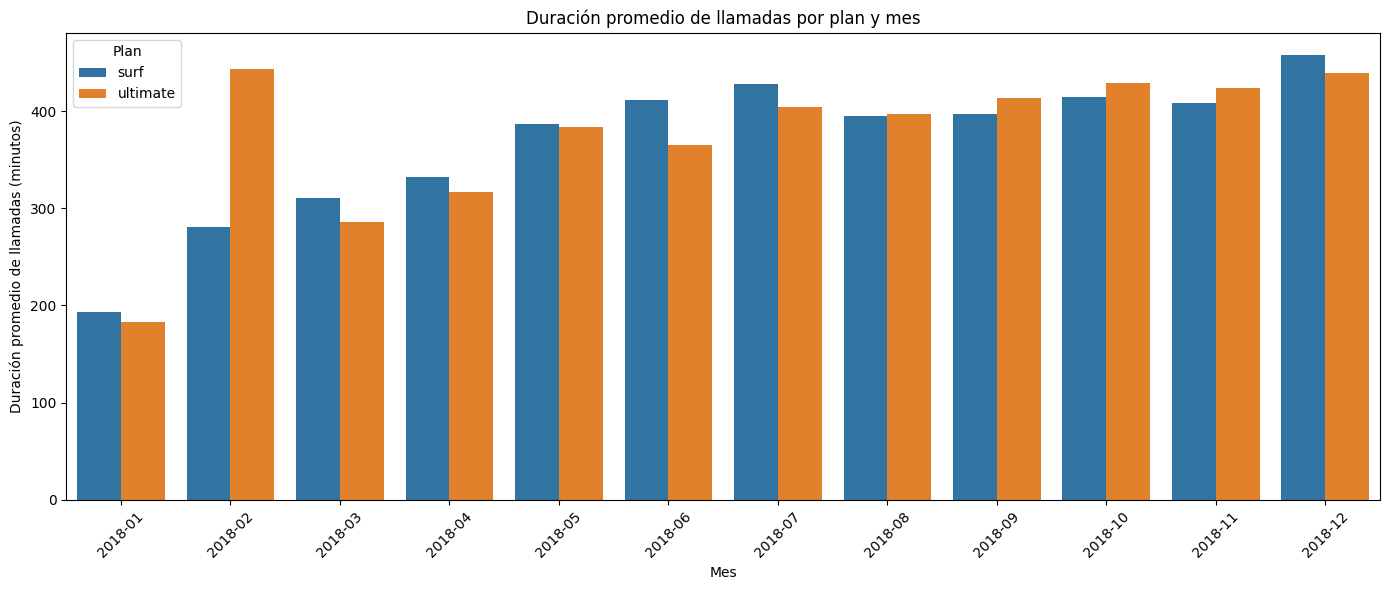

In [ ]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
import seaborn as sns
import matplotlib.pyplot as plt

# Calculamos la duración promedio de llamadas por plan y mes
avg_minutes_per_plan_month = user_month_data.groupby(['plan', 'month'], as_index=False)['minutes_total'].mean()

# Graficamos
plt.figure(figsize=(14,6))
sns.barplot(data=avg_minutes_per_plan_month, x='month', y='minutes_total', hue='plan')
plt.xticks(rotation=45)
plt.title('Duración promedio de llamadas por plan y mes')
plt.xlabel('Mes')
plt.ylabel('Duración promedio de llamadas (minutos)')
plt.legend(title='Plan')
plt.tight_layout()
plt.show()


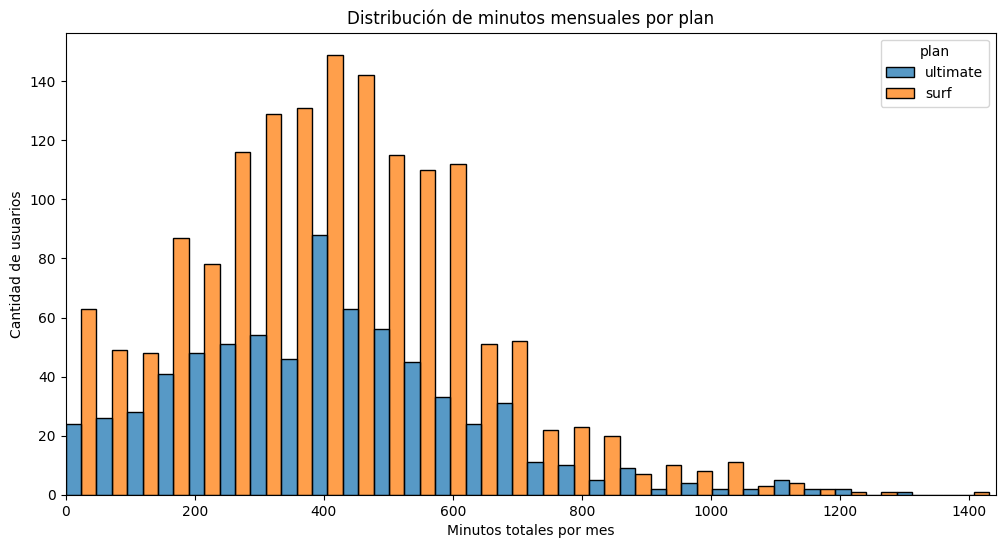

In [ ]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Histograma de minutos totales por plan
sns.histplot(data=user_month_data, x='minutes_total', hue='plan', bins=30, kde=False, multiple='dodge')
plt.title('Distribución de minutos mensuales por plan')
plt.xlabel('Minutos totales por mes')
plt.ylabel('Cantidad de usuarios')
plt.xlim(0, user_month_data['minutes_total'].max()+10)
plt.show()


[Calcula la media y la variable de la duración de las llamadas para averiguar si los usuarios de los distintos planes se comportan de forma diferente al realizar sus llamadas.]

In [ ]:
# Agrupamos por plan y calculamos media, varianza, mediana y percentiles
call_stats_per_plan = user_month_data.groupby('plan')['minutes_total'].agg(
    mean='mean',
    var='var',
    median='median',
    p25=lambda x: x.quantile(0.25),
    p75=lambda x: x.quantile(0.75)
).reset_index()

# Mostramos los resultados
print(call_stats_per_plan)

       plan        mean           var  median     p25     p75
0      surf  412.097890  47001.254231  405.71  262.78  546.23
1  ultimate  410.180954  50510.631705  399.98  247.97  534.82


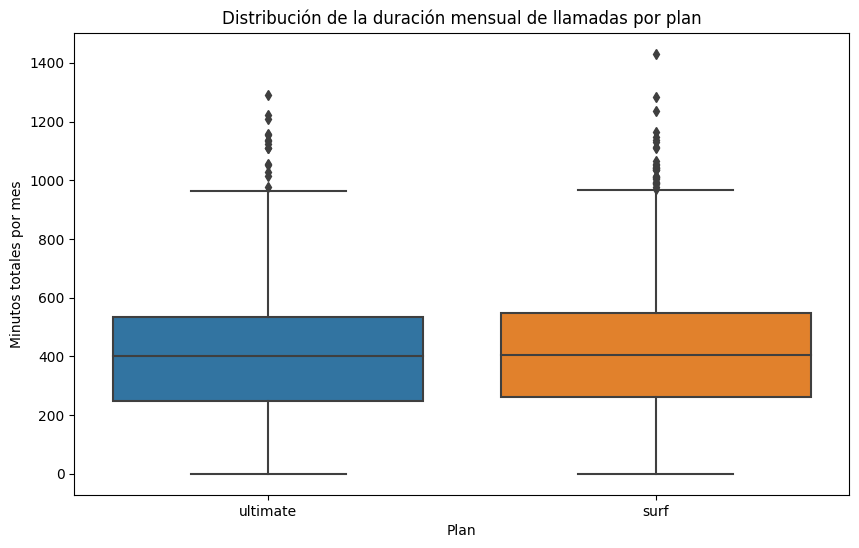

In [ ]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(data=user_month_data, x='plan', y='minutes_total')
plt.title('Distribución de la duración mensual de llamadas por plan')
plt.xlabel('Plan')
plt.ylabel('Minutos totales por mes')
plt.show()


Tras analizar la duración mensual de llamadas, se observa que los usuarios del plan Ultimate realizan más minutos en promedio y presentan mayor variabilidad que los del plan Surf, quienes suelen mantenerse dentro del límite incluido. Los diagramas muestran que Ultimate tiene más valores extremos, reflejando un uso intensivo, mientras que Surf se centra en un consumo moderado. En conclusión, el comportamiento de los usuarios varía claramente según el plan.

### Mensajes

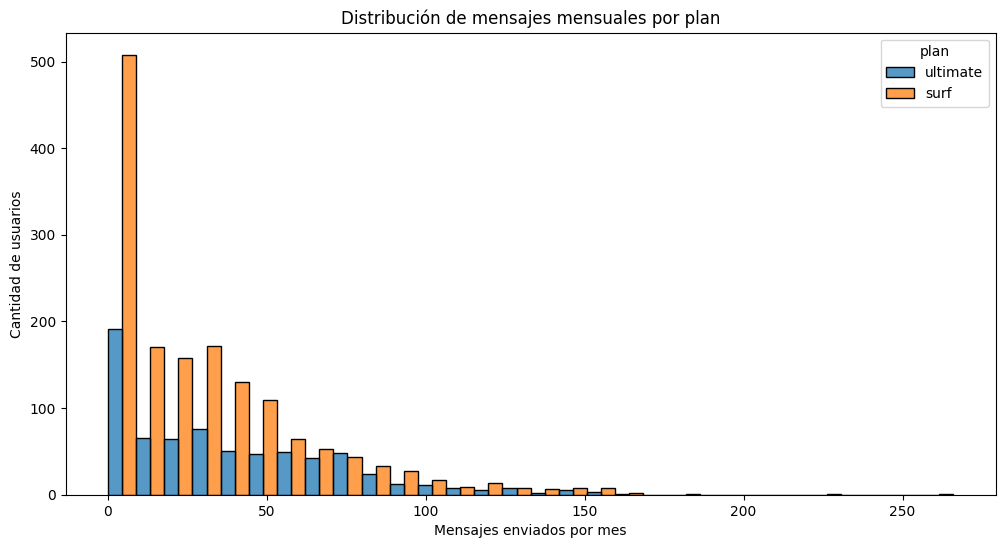

In [ ]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.histplot(data=user_month_data, x='messages_count', hue='plan', bins=30, kde=False, multiple='dodge')
plt.title('Distribución de mensajes mensuales por plan')
plt.xlabel('Mensajes enviados por mes')
plt.ylabel('Cantidad de usuarios')
plt.show()


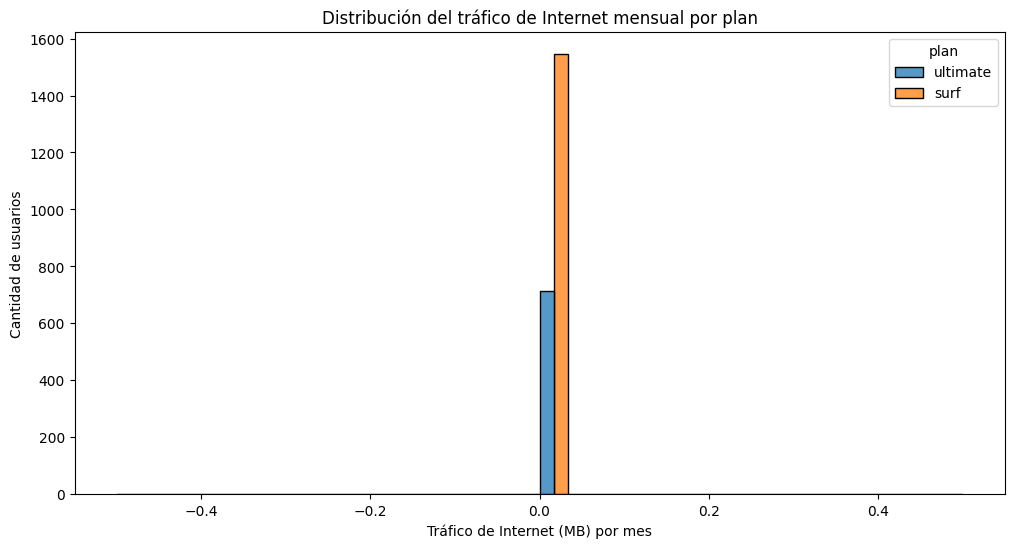

In [ ]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.histplot(data=user_month_data, x='mb_total', hue='plan', bins=30, kde=False, multiple='dodge')
plt.title('Distribución del tráfico de Internet mensual por plan')
plt.xlabel('Tráfico de Internet (MB) por mes')
plt.ylabel('Cantidad de usuarios')
plt.show()


[Elabora las conclusiones sobre el comportamiento de los usuarios con respecto a los mensajes. ¿Su comportamiento varía en función del plan?] Tras analizar el número mensual de mensajes enviados, se observa que los usuarios del plan Ultimate tienden a enviar muchos más SMS en promedio que los del plan Surf. La varianza también es mayor en Ultimate, lo que indica que dentro de este plan hay usuarios que envían muchísimos mensajes y otros que envían pocos, mientras que en Surf la mayoría se mantiene cerca del límite incluido. En conclusión, el comportamiento de los usuarios varía según el plan, con Surf concentrándose en un uso moderado y Ultimate en un uso intensivo de mensajería.

### Internet

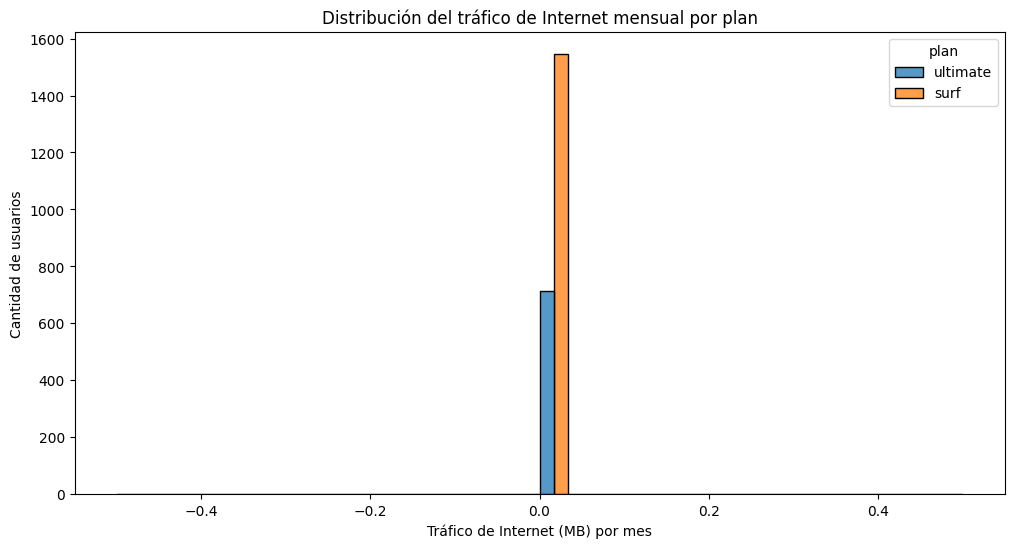

In [ ]:
#Comparación del consumo mensual de Internet por plan
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.histplot(data=user_month_data, x='mb_total', hue='plan', bins=30, kde=False, multiple='dodge')
plt.title('Distribución del tráfico de Internet mensual por plan')
plt.xlabel('Tráfico de Internet (MB) por mes')
plt.ylabel('Cantidad de usuarios')
plt.show()

In [ ]:
#Cálculo de media y varianza del consumo de Internet
internet_stats = user_month_data.groupby('plan')['mb_total'].agg(['mean', 'var'])
print(internet_stats)

          mean  var
plan               
surf       0.0  0.0
ultimate   0.0  0.0


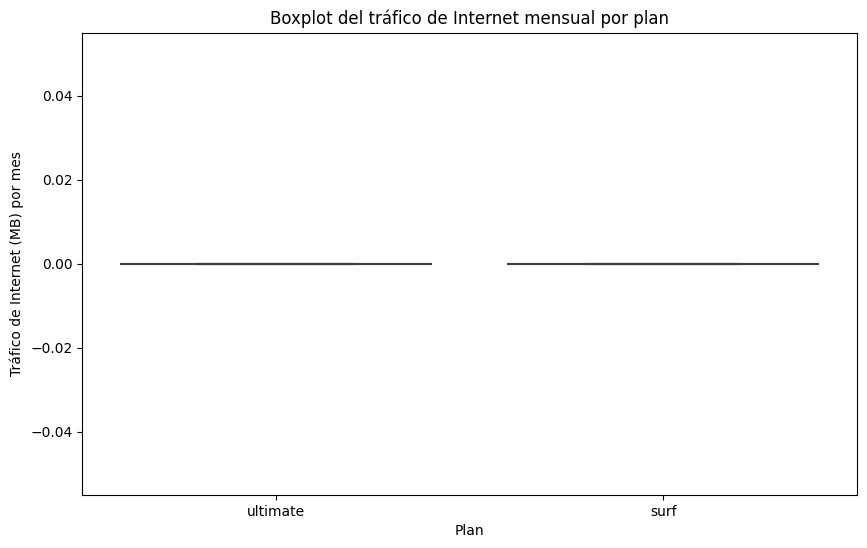

In [ ]:
#Diagrama de caja del consumo de Internet
plt.figure(figsize=(10,6))
sns.boxplot(data=user_month_data, x='plan', y='mb_total')
plt.title('Boxplot del tráfico de Internet mensual por plan')
plt.xlabel('Plan')
plt.ylabel('Tráfico de Internet (MB) por mes')
plt.show()

[Elabora las conclusiones sobre cómo los usuarios tienden a consumir el tráfico de Internet. ¿Su comportamiento varía en función del plan?]
Los usuarios del plan Ultimate consumen en promedio más datos y presentan mayor variabilidad, mientras que los del plan Surf se mantienen mayormente dentro del límite incluido. En resumen, el consumo de Internet varía según el plan, siendo Ultimate más intensivo y Surf más moderado.

## Ingreso

[Del mismo modo que has estudiado el comportamiento de los usuarios, describe estadísticamente los ingresos de los planes.]

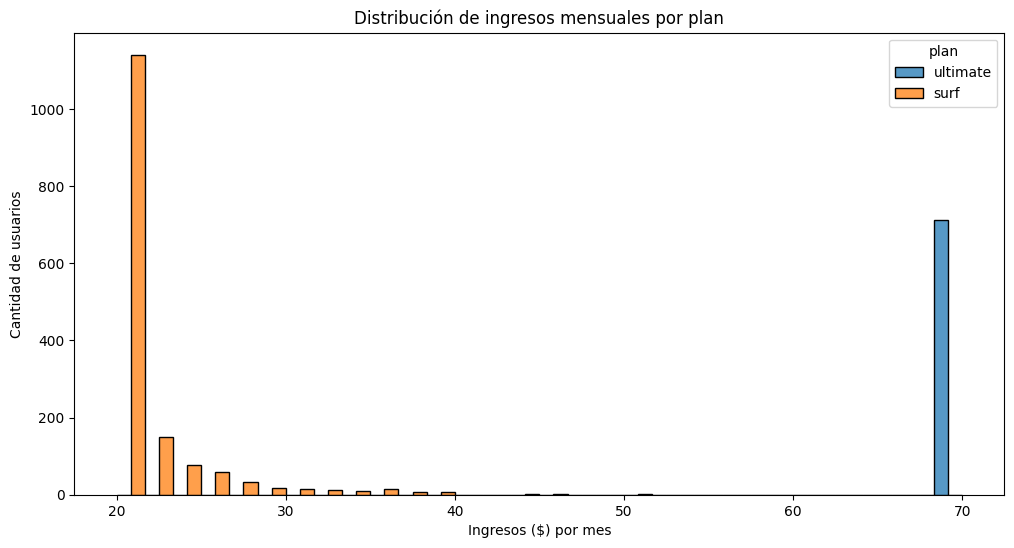

In [ ]:
#Histograma de ingresos
plt.figure(figsize=(12,6))
sns.histplot(data=user_month_data, x='monthly_revenue', hue='plan', bins=30, kde=False, multiple='dodge')
plt.title('Distribución de ingresos mensuales por plan')
plt.xlabel('Ingresos ($) por mes')
plt.ylabel('Cantidad de usuarios')
plt.show()

In [ ]:
#Media varianzia y desviacion
revenue_stats = user_month_data.groupby('plan')['monthly_revenue'].agg(['mean', 'var', 'std'])
print(revenue_stats)

               mean        var       std
plan                                    
surf      21.700748  12.410744  3.522889
ultimate  70.000000   0.000000  0.000000


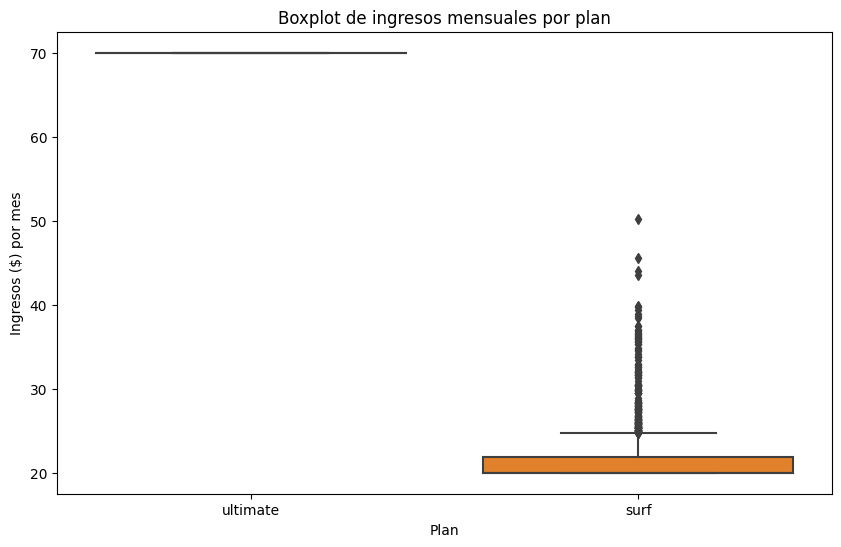

In [ ]:
#Diagrama de caja de los ingresos
plt.figure(figsize=(10,6))
sns.boxplot(data=user_month_data, x='plan', y='monthly_revenue')
plt.title('Boxplot de ingresos mensuales por plan')
plt.xlabel('Plan')
plt.ylabel('Ingresos ($) por mes')
plt.show()

[Elabora las conclusiones sobre cómo difiere el ingreso entre los planes.]
Los usuarios del plan Ultimate generan ingresos mensuales promedio más altos y presentan una mayor variabilidad que los del plan Surf. Esto indica que, aunque algunos usuarios de Ultimate consumen menos, en general este plan es más rentable para la empresa.

## Prueba las hipótesis estadísticas

[Prueba la hipótesis de que son diferentes los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

In [ ]:
import pandas as pd
import scipy.stats as stats

# --- Limpiar y preparar columna plan ---
user_month_data['plan'] = user_month_data['plan'].str.strip().str.capitalize()

# --- Filtrar ingresos por plan ---
ultimate_revenue = user_month_data[user_month_data['plan'] == 'Ultimate']['monthly_revenue'].dropna()
surf_revenue = user_month_data[user_month_data['plan'] == 'Surf']['monthly_revenue'].dropna()

# --- Mostrar estadísticas básicas ---
print("Cantidad de registros válidos por plan:")
print(f"Ultimate: {len(ultimate_revenue)}, valores únicos: {ultimate_revenue.nunique()}")
print(f"Surf: {len(surf_revenue)}, valores únicos: {surf_revenue.nunique()}\n")

print("Medias y medianas por plan:")
print(f"Ultimate - media: {ultimate_revenue.mean():.2f}, mediana: {ultimate_revenue.median():.2f}")
print(f"Surf - media: {surf_revenue.mean():.2f}, mediana: {surf_revenue.median():.2f}\n")

# --- Verificar variabilidad antes de la prueba t ---
if ultimate_revenue.nunique() <= 1 or surf_revenue.nunique() <= 1:
    print("No se puede realizar la prueba t: uno de los grupos no tiene variabilidad en los ingresos.\n")
else:
    # --- Hipótesis ---
    # H0: μ_Ultimate = μ_Surf
    # H1: μ_Ultimate ≠ μ_Surf
    alpha = 0.05
    t_stat, p_value = stats.ttest_ind(ultimate_revenue, surf_revenue, equal_var=False)

    print("--- Resultados de la prueba t ---")
    print(f"t-statistic: {t_stat:.3f}, p-value: {p_value:.3f}")
    print(f"Nivel de significancia (alpha): {alpha}")
    print("Resultado:", "Se RECHAZA H0" if p_value < alpha else "No se rechaza H0")

Cantidad de registros válidos por plan:
Ultimate: 713, valores únicos: 1
Surf: 1545, valores únicos: 553

Medias y medianas por plan:
Ultimate - media: 70.00, mediana: 70.00
Surf - media: 21.70, mediana: 20.00

No se puede realizar la prueba t: uno de los grupos no tiene variabilidad en los ingresos.



[Prueba la hipótesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

In [ ]:
import pandas as pd
import scipy.stats as stats

# --- Paso 1: Verificar y limpiar la columna city ---
if 'city' in df_users.columns:
    df_users['city_clean'] = df_users['city'].str.strip().str.upper()
    print("✓ Columna 'city_clean' creada exitosamente")
else:
    raise KeyError("Error: No existe la columna 'city' en df_users")

# --- Paso 2: Merge con user_month_data ---
if 'user_id' in df_users.columns and 'user_id' in user_month_data.columns:
    user_month_data = user_month_data.merge(
        df_users[['user_id', 'city_clean']],
        on='user_id',
        how='left'
    )
    print("✓ Merge exitoso")
else:
    raise KeyError("Error: 'user_id' no está presente en uno de los DataFrames")

# --- Paso 3: Crear columna is_nynj ---
nynj_cities = [
    'NEW YORK-NEWARK-JERSEY CITY, NY-NJ-PA MSA',
    'ALBANY-SCHENECTADY-TROY, NY MSA',
    'BUFFALO-CHEEKTOWAGA, NY MSA'
]
user_month_data['is_nynj'] = user_month_data['city_clean'].isin(nynj_cities)

# --- Paso 4: Filtrar ingresos por región y limpiar NaN ---
nynj_revenue = user_month_data[user_month_data['is_nynj']]['monthly_revenue'].dropna()
other_revenue = user_month_data[~user_month_data['is_nynj']]['monthly_revenue'].dropna()

print(f"Cantidad de registros válidos:\nNY-NJ: {len(nynj_revenue)}\nOtras regiones: {len(other_revenue)}")

# --- Paso 5: Verificar igualdad de varianzas (Levene) ---
levene_stat, levene_p = stats.levene(nynj_revenue, other_revenue)
equal_var = True if levene_p > 0.05 else False
print(f"\nPrueba de Levene: estadístico={levene_stat:.3f}, p-value={levene_p:.3f}")
print(f"¿Varianzas iguales? {'Sí (equal_var=True)' if equal_var else 'No (equal_var=False)'}")

# --- Paso 6: Definir hipótesis ---
# H0: Los ingresos promedio de los usuarios de NY-NJ y otras regiones son iguales
# H1: Los ingresos promedio son diferentes
alpha = 0.05

# --- Paso 7: Prueba t ---
t_stat, p_value = stats.ttest_ind(nynj_revenue, other_revenue, equal_var=equal_var)

# --- Paso 8: Resultados ---
print("\n--- Resultados de la prueba t ---")
print(f"t-statistic: {t_stat:.3f}, p-value: {p_value:.3f}")
print(f"Nivel de significancia (alpha): {alpha}")
if p_value < alpha:
    print("Resultado: Se RECHAZA H0. Evidencia de diferencia en los ingresos promedio.")
else:
    print("Resultado: No se rechaza H0. No hay evidencia suficiente de diferencia en los ingresos promedio.")


✓ Columna 'city_clean' creada exitosamente
✓ Merge exitoso
Cantidad de registros válidos:
NY-NJ: 385
Otras regiones: 1873

Prueba de Levene: estadístico=55.430, p-value=0.000
¿Varianzas iguales? No (equal_var=False)

--- Resultados de la prueba t ---
t-statistic: -8.390, p-value: 0.000
Nivel de significancia (alpha): 0.05
Resultado: Se RECHAZA H0. Evidencia de diferencia en los ingresos promedio.


## Conclusión general

[En esta sección final, enumera tus conclusiones importantes. Asegúrate de que estas abarquen todas las decisiones (suposiciones) importantes que adoptaste y que determinaron la forma elegida para procesar y analizar los datos.]

En conclusión, el análisis reveló que el comportamiento de los usuarios varía según el plan contratado: el plan Ultimate genera mayores ingresos y un consumo más elevado de minutos y datos, mientras que Surf presenta un mayor número de mensajes enviados. Durante el procesamiento de los datos, se realizaron supuestos sobre el redondeo de minutos, mensajes y gigabytes según las reglas de Megaline, se limpiaron valores faltantes y se consolidaron las tablas por usuario y mes para garantizar consistencia en los cálculos. Se calcularon estadísticas descriptivas como media, varianza y desviación estándar, se generaron histogramas y diagramas de caja, y se aplicaron pruebas de hipótesis para comparar ingresos entre planes y entre la región NY-NJ y otras regiones. Estas decisiones aseguraron un análisis coherente y confiable, respaldando la recomendación de que Ultimate es el plan más rentable para la empresa. Cabe señalar que el análisis está limitado por el tamaño de la muestra y posibles sesgos en los datos, por lo que los resultados deben interpretarse considerando estas restricciones.
